# Introduction to Geographic Data Science

## Contents

1.  [Spatial data](#spatial-data) 

2.  [Projection](#projection)

3.  [Plotting](#plotting)
    
4.  [Maven Car-Sharing Service](#maven-car-sharing-service)

5.  [References](#references)
---

## Spatial Data

A Geographic Information System (GIS) is a computer-based system to aid in the collection, maintenance, storage, analysis, output, and distribution of spatial data and information {cite}`gis_fundamentals`.



### Read Geospatial Data Files

Geospatial data files come in a variety of formats. Below are some of the most popular file types:
- Shapefiles (`.shp`)
- GeoJSON (`.geojson`)
- Geography Markup Language (`.gml`)
- Google's Keyhole Markup Language (`.kml`)
- OpenStreetMap XML (`.osm`)
- Comma-separated values (`.csv`)



These file formats store geospatial data in different ways, and each offers various advantages and disadvantages.
For example, `.shp` is a widely-used file format, supported by nearly every open source and commercial GIS software, while `.geojson` files are natively compatible with JavaScript, making it excellent for web-based mapping applications.

:::{note}
The above file formats are all used to represent **vector** data (points, edges, polygons). **Raster** files (i.e. photogrammetry), are typically stored as `.tiff`,`.jp2`, or `.bmp` files.)
:::

Below is a typical example of opening a `.shp` using `geopandas`. This particular file was downloaded from the Province of Ontario's Data Catalogue{cite}`ontario_health`.

In [16]:
import geopandas as gpd

# file downloaded from https://data.ontario.ca/dataset/ontario-s-health-region-geographic-data
ontario = gpd.read_file(r"data/ontario_health_regions/Ontario_Health_Regions.shp")

ontario

Shape_Leng    Shape_Area   REGION REGION_ID  \
0  4.845977e+06  1.089122e+11     East        04   
1  3.211510e+07  2.232211e+12    North        05   
2  4.860262e+06  7.543033e+10     West        01   
3  2.755817e+06  3.189867e+10  Central        02   
4  2.196396e+05  3.715020e+08  Toronto        03   

                                            geometry  
0  MULTIPOLYGON (((-8631925.914 5449844.839, -863...  
1  MULTIPOLYGON (((-8943097.220 5627248.576, -894...  
2  MULTIPOLYGON (((-9204865.114 5113839.368, -920...  
3  MULTIPOLYGON (((-8872905.739 5371938.215, -887...  
4  MULTIPOLYGON (((-8839514.979 5425932.689, -883...

As you can see, the `shapefile` we opened contains five entries (index 0 to 4).

Geopandas typically represents data in the following format {cite}`geopandas_image`:
![](../images/dataframe.svg)

As you can see from our table output above, this particular shapefile contains `Shape_Leng`, `Shape_Area`, `REGION`, and `REGION_ID` as data columns, and stores the features as `MULTIPOLYGON`.

:::{note}
The regions in this file are stored as multipolygon because some regions contain multiple land masses. You can read more about shapely multipolygons [here](https://shapely.readthedocs.io/en/stable/manual.html#collections-of-polygons).

### Data Plotting

Now that we have the file loaded into `geopandas`, we can plot it to visualize and analyze the data.

<AxesSubplot:>

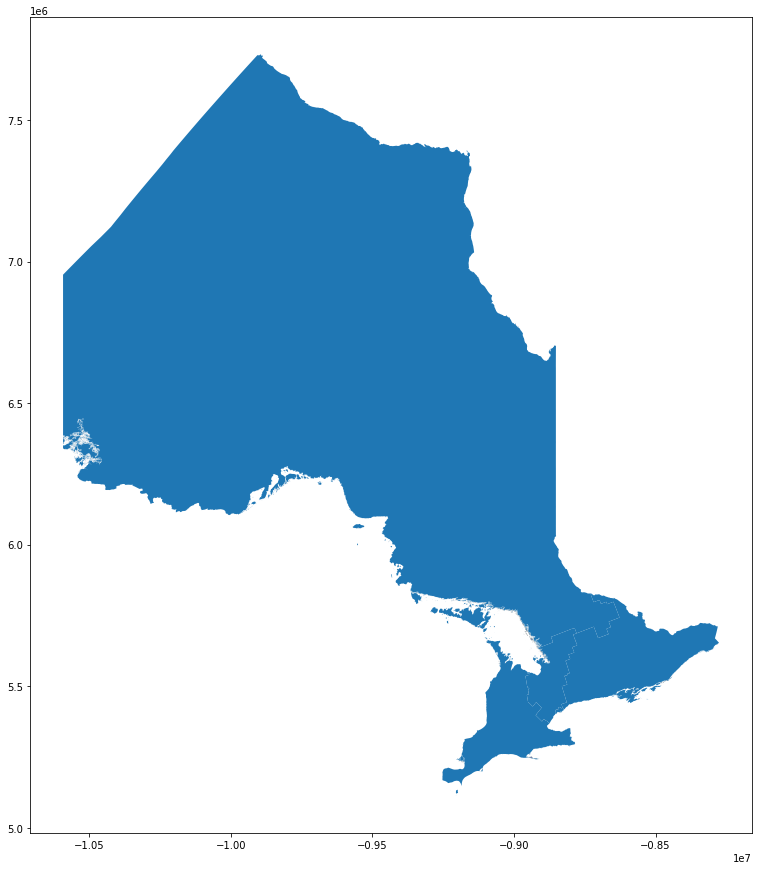

In [17]:
ontario.plot(figsize=(15,15))

We can also inspect metadata about the dataset. This includes column names, data types, as well as size (in memory) of the dataframe.

In [18]:
ontario.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Shape_Leng  5 non-null      float64 
 1   Shape_Area  5 non-null      float64 
 2   REGION      5 non-null      object  
 3   REGION_ID   5 non-null      object  
 4   geometry    5 non-null      geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 328.0+ bytes


## Projection

One of the fundamental problems surrounding mapping is the mismatch between the 2D nature of paper (and digital) maps and the 3D world we are trying to map. Just like geospatial data filetypes, there exist various map projections. Below are two of the most common map projections in GIS:


- `WGS 84/World Geodetic System, 1984 (EPSG:4326)` 
    represents the world as an ellipsoid, and uses degrees as a unit of measurement. It is commonly used in GPS applications. When you reference something by latitude and longitude, it is projected in `WGS 84`.

- `WGS 84/Pseudo-Mercator (EPSG:3857)`
    is used by popular mapping platforms like OpenStreetMaps, Google, as well as by GIS applications like ArcGIS. It projects ellipsoidal coordinates on a sphere, and uses metres as its unit. Errors of scale and distance exist, up to 0.7 percent and 43 km, respectively {cite}`epsg3857`


We can check the projection of our `geopandas` dataframe using the following:

In [19]:
ontario.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Let's reproject the map into `WGS 84`. Let's also filter out Northern Ontario, as we would like to focus more on the southern part of the province.

We can also customize the map to improve readability. Let's add a legend, borders, as well as different colours for each region.

Text(0.5, 1.0, 'WGS84 (lat/lon)')

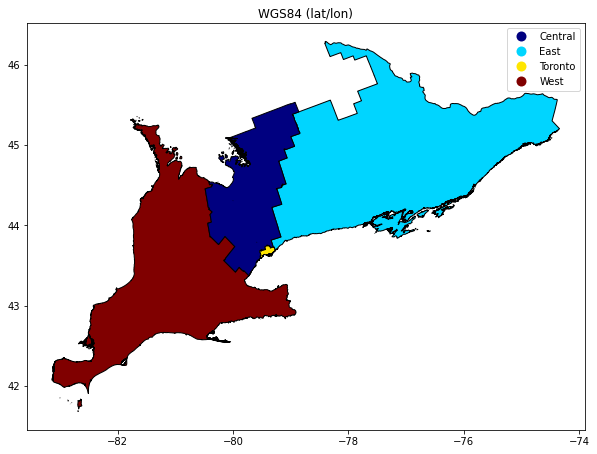

In [20]:
ontario = ontario.to_crs('EPSG:4326')
ontario = ontario[(ontario.REGION != "North")]
ax=ontario.plot(cmap='jet', edgecolor='black', column='REGION', figsize=(10,10), legend=True)
ax.set_title('WGS84 (lat/lon)')

You will notice that the axis markers above have changed to indicate latitude/longitude, whereas in the first map they were in metres.

Let's add a basemap tile below the polygons. Here, we will opt for OpenStreetMaps as tile provider. Normally, OSM requires `EPSG:3857`, as its [Mapnik](https://wiki.openstreetmap.org/wiki/Mapnik) renderer operates in `Web Mercator` projection. However, we can instead "warp" the incoming map tiles to fit our data by passing our dataframe's CRS into the `add_basemap` method. Below we've shown what the two different projections look like, side-by-side:

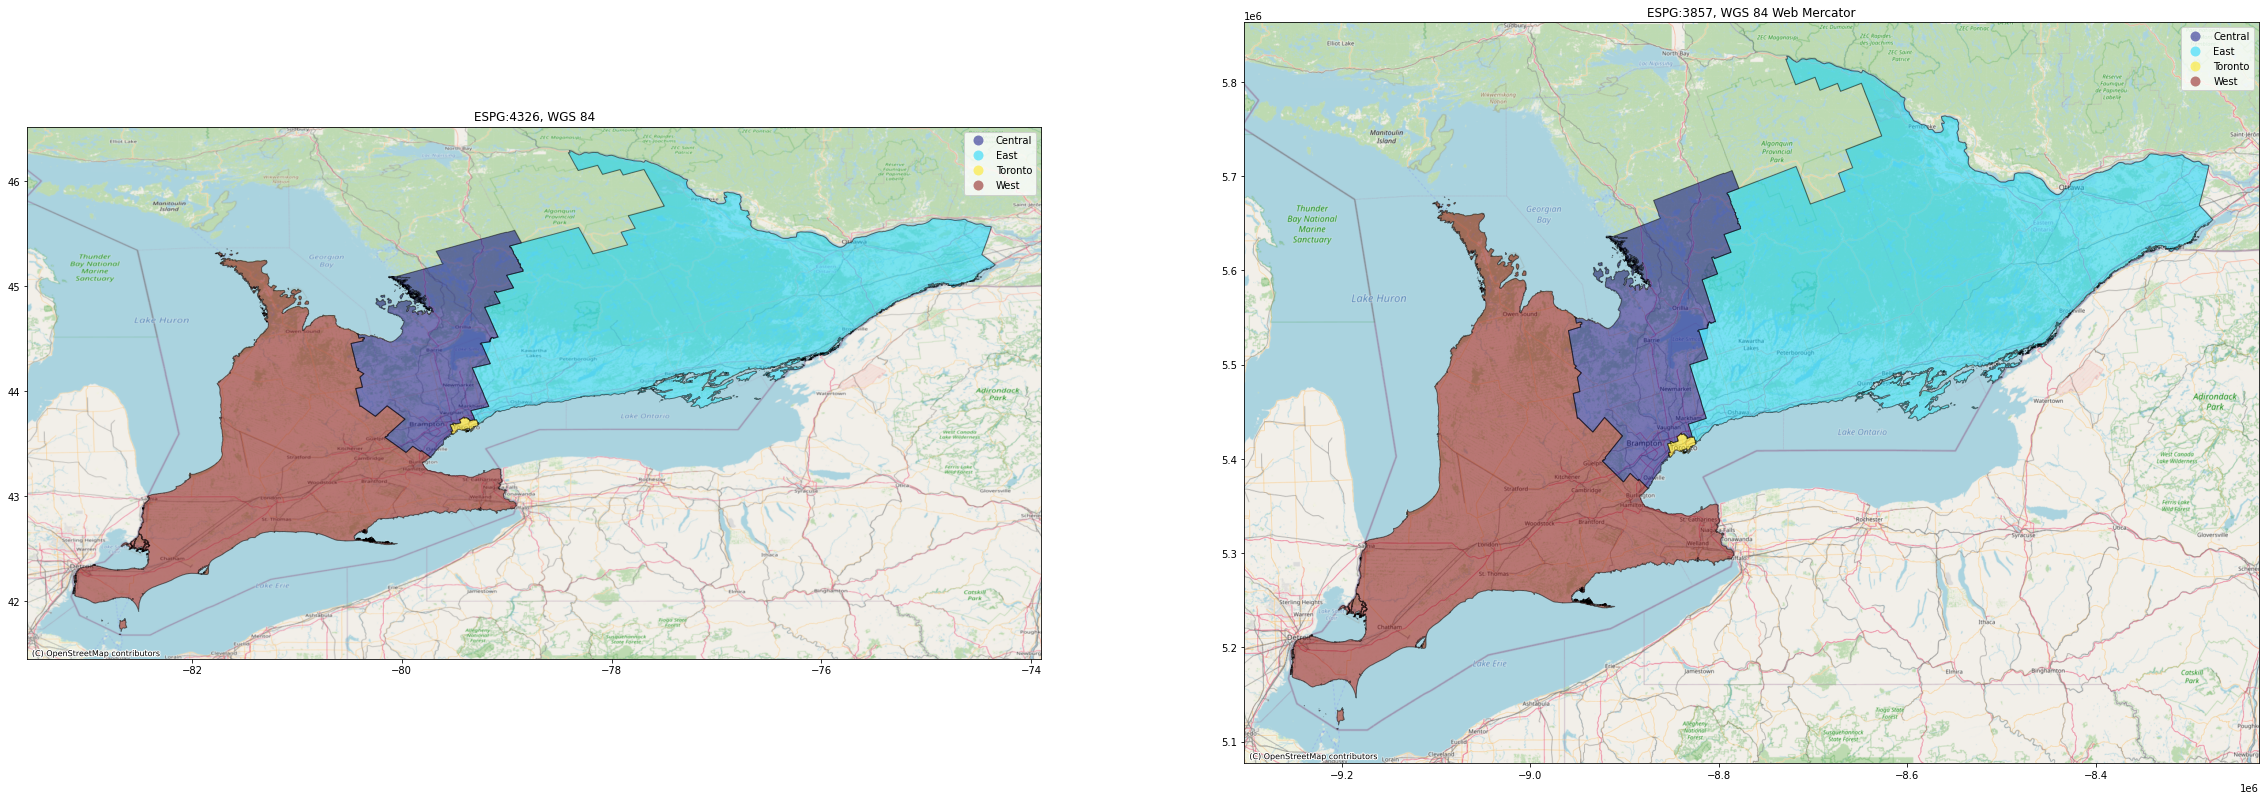

In [21]:
import contextily as ctx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, figsize=(40,20))
ax1=ontario.plot(cmap='jet', edgecolor='black', column='REGION', alpha=0.5, legend=True, ax=ax[0])
ax1.set_title("EPSG:4326, WGS 84")
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik, crs=ontario.crs.to_string())
ontario = ontario.to_crs(epsg=3857) 
ax2=ontario.plot(cmap='jet', edgecolor='black', column='REGION', alpha=0.5, legend=True, ax=ax[1])
ax2.set_title("EPSG:3857, WGS 84 Web Mercator")
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)

## Plotting

### Using [matplotlib](https://matplotlib.org/)

Up to this point we have been plotting our maps using the `matplotlib` package, which is built into `geopandas`. While `matplotlib` is both easy to use and already known to many python users (as it is popular for graphing in general), it has the drawback that it is not interactive.

### Using [folium](http://python-visualization.github.io/folium/)

`folium` is a python package built to allow the use of `leaflet`, an open-source JavaScript library. `leaflet` is an interactive map development toolkit that powers a lot of web-based interactive maps. Alternatives to `leaflet` include [MapBox](https://www.mapbox.com/), [Google Maps](https://developers.google.com/maps/documentation), as well as many other paid services.

Also built upon `leaflet` is `ipyleaflet`, which is a package designed specifically for rendering `leaflet` maps in Jupyter Notebook. While leaflet is highly interactive and easily builds beautiful maps with little configuration, it depends on JavaScript in order to function.

Let's replot the above map in `folium`. Note that `folium` expects geospatial data to be in `EPSG:4326`, so we will need to reproject it back to `WGS 84`.

In [22]:
import folium

# Reproject the dataframe back to WGS 84 so folium can read it properly
ontario = ontario.to_crs(epsg=4326)

# Set starting location, initial zoom, and base layer source.
m = folium.Map(location=[43.67621,-79.40530],zoom_start=6, tiles='cartodbpositron')

# Iterate through each entry in the geopandas DataFrame
for index, row in ontario.iterrows():

    # Simplify each region's polygon as intricate details are unnecessary
    sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)

    # Convert each polygon to JSON
    geo_j = sim_geo.to_json()

    # Convert the JSON to a folium GeoJSON, and add some style information
    geo_j = folium.GeoJson(data=geo_j, name=row['REGION'],style_function=lambda x: {'fillColor': 'black'})
    
    # Add a popup when clicking on a region
    folium.Popup(row['REGION']).add_to(geo_j)
    
    # Add the feature to the folium map
    geo_j.add_to(m)

m

:::{note}
You can click anywhere inside the marked regions to show a popup indicating the region's name.
This folium map uses OpenStreetMaps's CartoDB styling for a base layer tileset. You can read more about using custom tilesets [here](http://python-visualization.github.io/folium/modules.html#module-folium.folium).

### Elevation Data

We can also retrieve interesting geospatial information in the form of elevation data.

Let's first get the centroids for each region:

In [23]:
ontario['centroid'] = ontario.centroid
ontario

/tmp/ipykernel_2823/4260188429.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ontario['centroid'] = ontario.centroid


Shape_Leng    Shape_Area   REGION REGION_ID  \
0  4.845977e+06  1.089122e+11     East        04   
2  4.860262e+06  7.543033e+10     West        01   
3  2.755817e+06  3.189867e+10  Central        02   
4  2.196396e+05  3.715020e+08  Toronto        03   

                                            geometry  \
0  MULTIPOLYGON (((-77.54191 43.89913, -77.54234 ...   
2  MULTIPOLYGON (((-82.68871 41.68453, -82.68631 ...   
3  MULTIPOLYGON (((-79.70667 43.39271, -79.70805 ...   
4  MULTIPOLYGON (((-79.40671 43.74414, -79.40648 ...   

                     centroid  
0  POINT (-77.18411 44.89013)  
2  POINT (-81.07741 43.36065)  
3  POINT (-79.65677 44.45330)  
4  POINT (-79.40531 43.67619)

:::{warning}
Notice that calculating the centroid raises a warning. That's because we are using `EPSG:4326`, which uses degrees as a unit of measure. This makes polygon calculations inaccurate, especially at larger scales. We will ignore this warning for this example, but keep in mind that centroids will not be accurate in this projection. For better results, you can calculate the centroids of a projection that uses a flat projection (that retains area) and then reproject it back to `EPSG:4326`. 

For web use, when the desired effect is a *visual* centroid, it is possible to continue using a Mercator projection like `EPSG:4326`, while applications that require a "true" centroid should use a projection like `Equal Area Cylindrical`, which avoids distortion at the poles. See [here](https://proj.org/operations/projections/cea.html) for more details.
:::

Now, let's query the [Open Elevation API](https://open-elevation.com/) for the elevation (in metres) at the centroids for each region.

In [24]:
from requests import get

def get_elevation(centroid):

    query = (f'https://api.open-elevation.com/api/v1/lookup?locations={centroid.y},{centroid.x}')

    # Set a timeout on the request in case of a slow response
    r = get(query,timeout=30)

    # Only use the response if the status is successful
    if r.status_code!=200 and r.status_code!=201: return None

    elevation = r.json()['results'][0]['elevation']

    return elevation

elevations = []

for index, row in ontario.iterrows():

    elevations.append(get_elevation(row['centroid']))
    
ontario['elevations'] = elevations

ontario

Shape_Leng    Shape_Area   REGION REGION_ID  \
0  4.845977e+06  1.089122e+11     East        04   
2  4.860262e+06  7.543033e+10     West        01   
3  2.755817e+06  3.189867e+10  Central        02   
4  2.196396e+05  3.715020e+08  Toronto        03   

                                            geometry  \
0  MULTIPOLYGON (((-77.54191 43.89913, -77.54234 ...   
2  MULTIPOLYGON (((-82.68871 41.68453, -82.68631 ...   
3  MULTIPOLYGON (((-79.70667 43.39271, -79.70805 ...   
4  MULTIPOLYGON (((-79.40671 43.74414, -79.40648 ...   

                     centroid  elevations  
0  POINT (-77.18411 44.89013)         274  
2  POINT (-81.07741 43.36065)         353  
3  POINT (-79.65677 44.45330)         261  
4  POINT (-79.40531 43.67619)         125

Here they are plotted on the map, using Markers to show the centroid location. You can click on the marker to show the elevation at that point.

In [25]:
for index, row in ontario.iterrows():
    folium.Marker(location=[row['centroid'].y,row['centroid'].x], popup='Elevation: {}'.format(row['elevations'])).add_to(m)
m

### Custom Polygons

We can also plot some custom polygons on our map.

For this particular example, let's plot the [three campuses](https://www.utoronto.ca/university-life/campuses) of the University of Toronto on a map of Toronto. The campus polygons were generated manually using [QGIS](https://www.qgis.org/en/site/), but they can also be done in any GIS editor like [ArcGIS](https://www.arcgis.com/index.html) or [AutoCAD Map 3D](https://www.autodesk.ca/en/products/autocad/included-toolsets/autocad-map-3d). 

<AxesSubplot:>

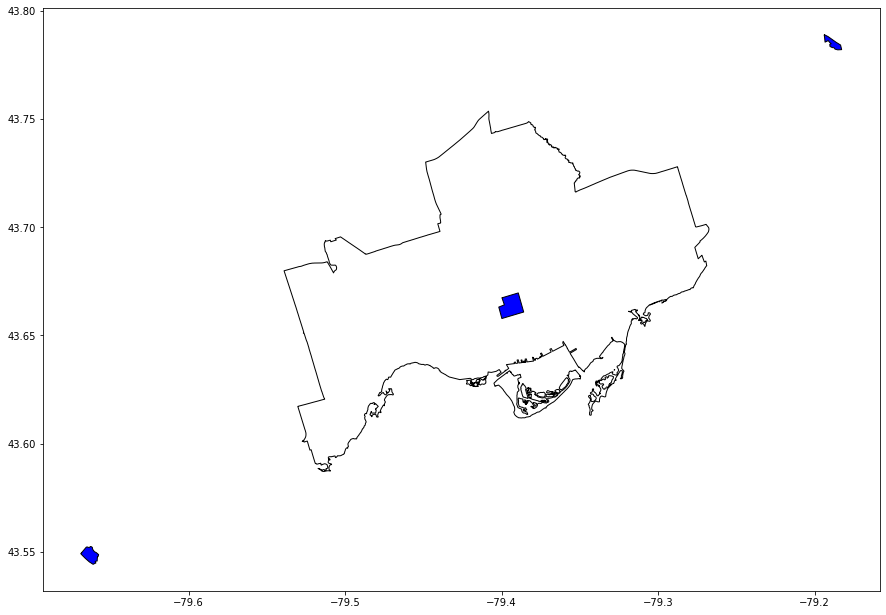

In [26]:
import matplotlib.pyplot as plt

# This file was created using the QGIS Editor
uoft = gpd.read_file(r"data/QGIS/UofT.shp")

fig, ax = plt.subplots(figsize=(15,15))

toronto = ontario[(ontario.REGION == "Toronto")]
toronto.plot(ax=ax, color='none',edgecolor='black')
uoft.plot(ax=ax, color='blue', edgecolor='black')

This is nice, but we can see that two of the polygons (two campuses of the University of Toronto) are floating in the middle of nowhere. That's because our Ontario dataset only encompasses most of downtown Toronto, but ignores the other boroughs. Let's use a Toronto municipal map instead. In this example, we'll actually read the input as a `.geojson` file. It works the same way as `.shp` files. Let's use the Toronto municipalities as a base layer, and plot the University of Toronto campuses on top of it.

<AxesSubplot:>

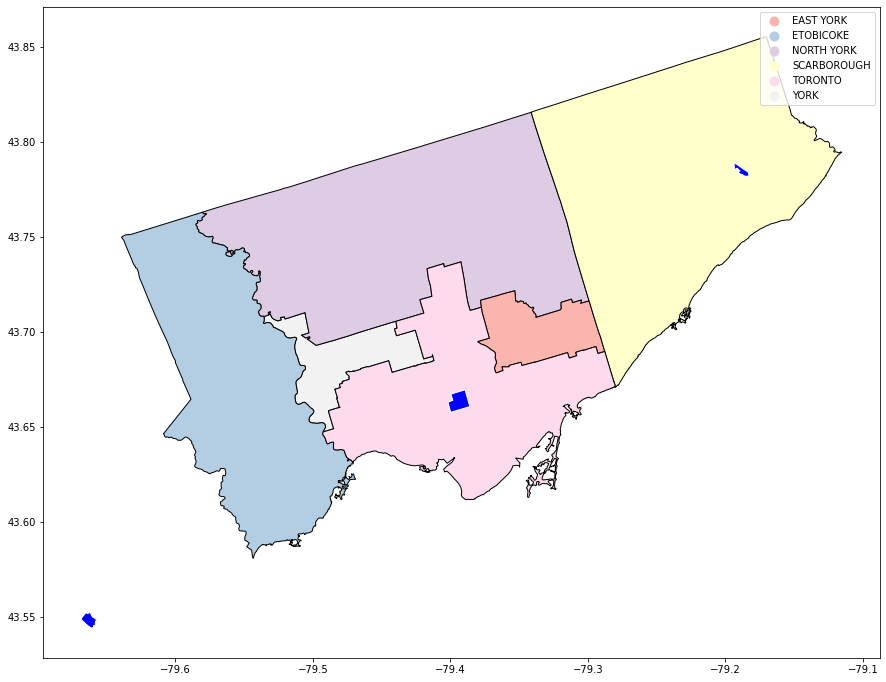

In [27]:
fig, ax = plt.subplots(figsize=(15,15))
toronto = gpd.read_file(r"data/TorontoBoundary.geojson")
toronto.plot(ax=ax, cmap='Pastel1', edgecolor='black', column='AREA_NAME', figsize=(15,15), legend=True)
uoft.plot(ax=ax, color='blue', edgecolor='white')

Almost there! The Mississauga campus (bottom left) is still in limbo. That's because Mississauga is part of Peel Region, which is outside of Toronto. Let's redo the map, including the Mississauga boundaries! This time, we'll use a `.kml` file for the input. KML files are not supported by default by `geopandas`, so we'll need to use a "driver" to read it. Fortunately, we can leverage `fiona`, a powerful python IO API, which is already built into `geopandas`.

In [28]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
missisauga = gpd.read_file(r"data/MissBoundary.kml",driver='KML')
missisauga

Name Description                                           geometry
0                   MULTIPOLYGON (((-79.63657 43.73509, -79.63405 ...

Since there's only one entry in this file, we can actually append this to our existing "Toronto" dataframe like so:

In [29]:
new_row = {
    'AREA_NAME' : 'MISSISSAUGA',
    'geometry': missisauga['geometry'][0]
}
gta = toronto.append(new_row, ignore_index=True)

Now let's try plotting the University of Toronto campuses again...

<AxesSubplot:>

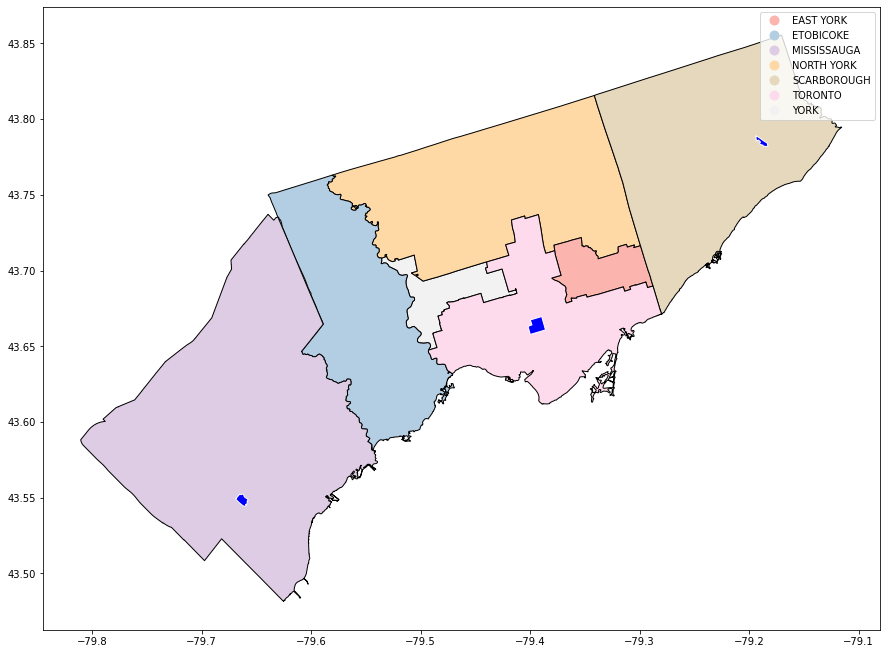

In [30]:
fig, ax = plt.subplots(figsize=(15,15))
gta.plot(ax=ax, cmap='Pastel1', edgecolor='black', column='AREA_NAME', figsize=(15,15), legend=True)
uoft.plot(ax=ax, color='blue', edgecolor='white')

:::{admonition} Going further
:class: tip
As an exercise, we could try adding Markers and/or Popups to the campuses, to show their names when clicked. Alternatively we could also change the basemap layer to a road network map (like OpenStreetMap), and plot the shortest distance (by road) between the campuses...
:::

## Maven Car-Sharing Service

[Maven](https://media.gm.com/media/us/en/gm/home.detail.html/content/Pages/news/us/en/2020/apr/0421-maven.html) was a car-sharing program pilotted by General Motors. It sought to rent out vehicles for personal and commercial use, and was deployed across the US and Australia. While there were plans to expand the program to Canada beyond Toronto, the COVID-19 pandemic ultimately cause GM to abandon the program entirely {cite}`maven_cancel`. Let's imagine that GM plans now to relaunch the service in Toronto.

Maven works by allowing its users to pickup and dropoff its vehicles anywhere. Let's build a map to show the pickup and dropoff locations of past Maven rides. Let's also plot the location of Maven depots. These depots are where Maven might aggregate its vehicles for maintenance, refuelling, and redistribution to meet network demand. We'll be importing this data through `.csv` files.

In [31]:
depots = gpd.read_file(r"data/maven_depot.csv")
origins = gpd.read_file(r"data/maven_origin.csv")
destinations = gpd.read_file(r"data/maven_dest.csv")

Let's plot all of this using icons on an OpenStreetMap base layer.

In [32]:
m = folium.Map(location=[43.663774, -79.395981], tiles="OpenStreetMap", zoom_start=13)
for i in range(len(origins)):
    origin = origins.iloc[i]
    dest = destinations.iloc[i]
    depot = depots.iloc[i]

    folium.Marker(
        location = [dest['lat'],dest['lng']],
        popup = 'Destination: \n {}'.format(dest['address']),
        icon = folium.Icon(color='blue', icon='flag', prefix='fa')
    ).add_to(m)
    
    folium.Marker(
        location = [origin['lat'],origin['lng']],
        popup = 'Pickup: \n {}'.format(origin['address']),
        icon = folium.Icon(color='red', icon='car', prefix='fa')
    ).add_to(m)

    folium.Marker(
        location = [depot['lat'],depot['lng']],
        popup = 'Depot: \n {}'.format(depot['address']),
        icon = folium.Icon(color='green', icon='home', prefix='fa')
    ).add_to(m)

m

:::{admonition} Going further
:class: tip
We can also leverage tools like `osrm` to generate routes between the origin and destinations on this map. We could also calculate interesting metrics like minimum/maximum distance from a dropoff point to the nearest depot.

As a more challenging exercise, how could we calculate where each car goes for maintenance at the end of the day, assuming the following:

1. Each depot can only handle one car at a time.
2. Maven wants to minimize the distance driven between the car's dropoff point and its maintenance depot.
3. Alternatively, Maven may want to minimize the *time* spent while driving the car from its final dropoff point to its maintenance depot, as labour may be more expensive than fuel.
:::

## References
```{bibliography}
    :style: unsrt
```